In [ ]:
import os

os.chdir('../../../../data/PASNet/APNet_model_2/')

Mounted at /content/drive
/content/drive/My Drive/APNet_12-13-2024/PASNet/MGH-scMGH-Blish


# Pathways file input pre-processing

In [ ]:
import os
import pandas as pd

df = pd.read_excel("ins/pt.xlsx")

df['target_label'] = df['target_label'].str.split(';')

df_n = df.explode("target_label").pivot_table(index="source_label", columns="target_label", aggfunc="size", fill_value=0).reset_index()
df_n = df_n.set_index('source_label')

df_n.to_excel("ins/pt_fixed.xlsx")

In [ ]:
!pip install shap==0.42.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.0/548.0 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


# Load Libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import copy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix

import shap
import pickle

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
torch.manual_seed(0)

# Defs

## Dataloader

In [ ]:
def vectorized_label(target, n_class):
	'''convert target(y) to be one-hot encoding format(dummy variable)
	'''
	TARGET = np.array(target).reshape(-1)

	return np.eye(n_class)[TARGET]


def load_data(path, dtype):
	'''Load data, and then covert it to a Pytorch tensor.
	Input:
		path: path to input dataset (which is expected to be a csv file).
		dtype: define the data type of tensor (i.e. dtype=torch.FloatTensor)
	Output:
		X: a Pytorch tensor of 'x'.
		Y: a Pytorch tensor of 'y'(one-hot encoding).
	'''
	data = pd.read_excel(path)
	data = data.drop('Unnamed: 0', axis=1)

	x = data.drop(["Condition"], axis = 1).values
	y = data.loc[:, ["Condition"]].values

	X = torch.from_numpy(x).type(dtype)
	Y = torch.from_numpy(vectorized_label(y, 2)).type(dtype)
	###if gpu is being used
	if torch.cuda.is_available():
		X = X.cuda()
		Y = Y.cuda()
	###
	return(X, Y)


def load_pathway(path, dtype):
	'''Load a bi-adjacency matrix of pathways, and then covert it to a Pytorch tensor.
	Input:
		path: path to input dataset (which is expected to be a csv file).
		dtype: define the data type of tensor (i.e. dtype=torch.FloatTensor)
	Output:
		PATHWAY_MASK: a Pytorch tensor of the bi-adjacency matrix of pathways.
	'''
	# pathway_mask = pd.read_csv(path, index_col = 0).as_matrix()
	pathway_mask = pd.read_excel(path, index_col = 0)

	PATHWAY_MASK = torch.from_numpy(pathway_mask.values.astype(np.float32)).type(dtype)
	###if gpu is being used
	if torch.cuda.is_available():
		PATHWAY_MASK = PATHWAY_MASK.cuda()
	###
	return(PATHWAY_MASK)


## Evaluation function

In [ ]:
def auc(y_true, y_pred):
	###if gpu is being used, transferring back to cpu
	if torch.cuda.is_available():
		y_true = y_true.cpu().detach()
		y_pred = y_pred.cpu().detach()
	###
	auc = roc_auc_score(y_true.detach().numpy(), y_pred.detach().numpy())
	return(auc)

def f1(y_true, y_pred):
	###covert one-hot encoding into integer
	y = torch.argmax(y_true, dim = 1)
	###estimated targets (either 0 or 1)
	pred = torch.argmax(y_pred, dim = 1)
	###if gpu is being used, transferring back to cpu
	if torch.cuda.is_available():
		y = y.cpu().detach()
		pred = pred.cpu().detach()
	###
	f1 = f1_score(y.detach().numpy(), pred.detach().numpy())
	return(f1)

## Imbalance cost function

In [ ]:
def bce_for_one_class(predict, target, lts = False):
	'''calculate cross entropy in average for samples who belong to the same class.
	lts = False: non-LTS samples are obtained.
	'''
	lts_idx = torch.argmax(target, dim = 1)
	if lts == False:
		idx = 0 # label = 0, non-severe
	else: idx = 1 # label = 1, severe
	y = target[lts_idx == idx]
	pred = predict[lts_idx == idx]


	cost = F.binary_cross_entropy(pred, y)


	return(cost)

def binary_cross_entropy_for_imbalance(predict, target):
	'''claculate cross entropy for imbalance data in binary classification.'''
	total_cost = bce_for_one_class(predict, target, lts = True) + bce_for_one_class(predict, target, lts = False)

	return(total_cost)


## Model

In [ ]:
class PASNet(nn.Module):
	def __init__(self, In_Nodes, Pathway_Nodes, Hidden_Nodes, Out_Nodes, Pathway_Mask):
		super(PASNet, self).__init__()
		self.sigmoid = nn.Sigmoid()
		self.softmax = nn.Softmax(dim = 1)
		self.pathway_mask = Pathway_Mask
		###gene layer --> pathway layer
		self.sc1 = nn.Linear(In_Nodes, Pathway_Nodes)
		###pathway layer --> hidden layer
		self.sc2 = nn.Linear(Pathway_Nodes, Hidden_Nodes)
		###hidden layer --> Output layer
		self.sc3 = nn.Linear(Hidden_Nodes, Out_Nodes)
		###randomly select a small sub-network
		self.do_m1 = torch.ones(Pathway_Nodes)
		self.do_m2 = torch.ones(Hidden_Nodes)
		###if gpu is being used
		if torch.cuda.is_available():
			self.do_m1 = self.do_m1.cuda()
			self.do_m2 = self.do_m2.cuda()
		###

	def forward(self, x):
		###force the connections between gene layer and pathway layer w.r.t. 'pathway_mask'
		self.sc1.weight.data = self.sc1.weight.data.mul(self.pathway_mask)
		x = self.sigmoid(self.sc1(x))
		if self.training == True: ###construct a small sub-network for training only
			x = x.mul(self.do_m1)
		x = self.sigmoid(self.sc2(x))
		if self.training == True: ###construct a small sub-network for training only
			x = x.mul(self.do_m2)
		x = self.softmax(self.sc3(x)) # all rows add up to 1

		return x

## Subnetwork Sparce coding

In [ ]:
def dropout_mask(n_node, drop_p):
	'''Construct a binary matrix to randomly drop nodes in a layer.
	Input:
		n_node: number of nodes in the layer.
		drop_p: the probability that a node is to be dropped.
	Output:
		mask: a binary matrix, where 1 --> keep the node; 0 --> drop the node.
	'''
	keep_p = 1.0 - drop_p
	mask = torch.Tensor(np.random.binomial(1, keep_p, size=n_node))
	###if gpu is being used
	if torch.cuda.is_available():
		mask = mask.cuda()
	###
	return mask

def s_mask(sparse_level, param_matrix, nonzero_param_1D, dtype):
	'''Construct a binary matrix w.r.t. a sparsity level of weights between two consecutive layers
	Input:
		sparse_level: a percentage value in [0, 100) represents the proportion of weights in a sub-network to be dropped.
		param_matrix: a weight matrix for entrie network.
		nonzero_param_1D: 1D of non-zero 'param_matrix' (which is the weights selected from a sub-network).
		dtype: define the data type of tensor (i.e. dtype=torch.FloatTensor).
	Output:
		param_mask: a binary matrix, where 1 --> keep the node; 0 --> drop the node.
	'''
	###take the absolute values of param_1D
	non_neg_param_1D = torch.abs(nonzero_param_1D)
	###obtain the number of params
	num_param = nonzero_param_1D.size(0)
	###obtain the kth number based on sparse_level
	top_k = math.ceil(num_param*(100-sparse_level)*0.01)
	###obtain the k largest params
	sorted_non_neg_param_1D, indices = torch.topk(non_neg_param_1D, top_k)
	param_mask = torch.abs(param_matrix) > sorted_non_neg_param_1D.min()
	param_mask = param_mask.type(dtype)
	###if gpu is being used
	if torch.cuda.is_available():
		param_mask = param_mask.cuda()
	###
	return param_mask

## Train

In [ ]:
# @title
dtype = torch.FloatTensor
def trainPASNet(train_x, train_y, eval_x, eval_y, pathway_mask, \
			In_Nodes, Pathway_Nodes, Hidden_Nodes, Out_Nodes, \
			Learning_Rate, L2_Lambda, nEpochs, Dropout_Rates, optimizer = "Adam"):

	net = PASNet(In_Nodes, Pathway_Nodes, Hidden_Nodes, Out_Nodes, pathway_mask)
	###if gpu is being used
	if torch.cuda.is_available():
		net.cuda()
	###
	###the default optimizer is Adam
	if optimizer == "SGD":
		opt = optim.SGD(net.parameters(), lr=Learning_Rate, weight_decay = L2_Lambda)
	else: opt = optim.Adam(net.parameters(), lr=Learning_Rate, weight_decay = L2_Lambda)

	for epoch in range(nEpochs):
		net.train()
		opt.zero_grad() ###reset gradients to zeros
		###Randomize dropout masks
		net.do_m1 = dropout_mask(Pathway_Nodes, Dropout_Rates[0])
		net.do_m2 = dropout_mask(Hidden_Nodes, Dropout_Rates[1])

		pred = net(train_x) ###Forward
		# print(pred)
		loss = binary_cross_entropy_for_imbalance(pred, train_y) ###calculate loss
		loss.backward() ###calculate gradients
		opt.step() ###update weights and biases

		net.sc1.weight.data = net.sc1.weight.data.mul(net.pathway_mask) ###force the connections between gene layer and pathway layer

		###obtain the small sub-network's connections
		do_m1_grad = copy.deepcopy(net.sc2.weight._grad.data)
		do_m2_grad = copy.deepcopy(net.sc3.weight._grad.data)
		do_m1_grad_mask = torch.where(do_m1_grad == 0, do_m1_grad, torch.ones_like(do_m1_grad))
		do_m2_grad_mask = torch.where(do_m2_grad == 0, do_m2_grad, torch.ones_like(do_m2_grad))
		###copy the weights
		net_sc2_weight = copy.deepcopy(net.sc2.weight.data)
		net_sc3_weight = copy.deepcopy(net.sc3.weight.data)

		###serializing net
		net_state_dict = net.state_dict()

		###Sparse Coding
		###make a copy for net, and then optimize sparsity level via copied net
		copy_net = copy.deepcopy(net)
		copy_state_dict = copy_net.state_dict()
		for name, param in copy_state_dict.items():
			###omit the param if it is not a weight matrix
			if not "weight" in name:
				continue
			###omit gene layer
			if "sc1" in name:
				continue
			###sparse coding between the current two consecutive layers is in the trained small sub-network
			if "sc2" in name:
				active_param = net_sc2_weight.mul(do_m1_grad_mask)
			if "sc3" in name:
				active_param = net_sc3_weight.mul(do_m2_grad_mask)
			nonzero_param_1d = active_param[active_param != 0]
			if nonzero_param_1d.size(0) == 0: ###stop sparse coding between the current two consecutive layers if there are no valid weights
				break
			copy_param_1d = copy.deepcopy(nonzero_param_1d)
			###set up potential sparsity level in [0, 100)
			S_set =  torch.arange(100, -1, -10)[1:]
			copy_param = copy.deepcopy(active_param)
			S_loss = []
			for S in S_set:
				param_mask = s_mask(sparse_level = S.item(), param_matrix = copy_param, nonzero_param_1D = copy_param_1d, dtype = dtype)
				transformed_param = copy_param.mul(param_mask)
				copy_state_dict[name].copy_(transformed_param)
				copy_net.train()
				y_tmp = copy_net(train_x)
				loss_tmp = binary_cross_entropy_for_imbalance(y_tmp, train_y)
				S_loss.append(loss_tmp)
			###apply cubic interpolation
			S_loss = [tensor.detach() for tensor in S_loss]
			interp_S_loss = interp1d(S_set, S_loss, kind='cubic')
			interp_S_set = torch.linspace(min(S_set), max(S_set), steps=100)
			interp_loss = interp_S_loss(interp_S_set)
			optimal_S = interp_S_set[np.argmin(interp_loss)]
			optimal_param_mask = s_mask(sparse_level = optimal_S.item(), param_matrix = copy_param, nonzero_param_1D = copy_param_1d, dtype = dtype)

			if "sc2" in name:
				final_optimal_param_mask = torch.where(do_m1_grad_mask == 0, torch.ones_like(do_m1_grad_mask), optimal_param_mask)
				optimal_transformed_param = net_sc2_weight.mul(final_optimal_param_mask)
			if "sc3" in name:
				final_optimal_param_mask = torch.where(do_m2_grad_mask == 0, torch.ones_like(do_m2_grad_mask), optimal_param_mask)
				optimal_transformed_param = net_sc3_weight.mul(final_optimal_param_mask)
			###update weights in copied net
			copy_state_dict[name].copy_(optimal_transformed_param)
			###update weights in net
			net_state_dict[name].copy_(optimal_transformed_param)
		if epoch == nEpochs - 1:
			net.train()
			train_pred = net(train_x)
			train_loss = binary_cross_entropy_for_imbalance(train_pred, train_y).view(1,)

			net.eval()
			eval_pred = net(eval_x)
			eval_loss = binary_cross_entropy_for_imbalance(eval_pred, eval_y).view(1,)


	dw3 = pd.DataFrame(net_state_dict['sc3.weight'])
	dw3.to_excel('outs/sc3_weights.xlsx')
	db3 = pd.DataFrame(net_state_dict['sc3.bias'])
	db3.to_excel('outs/sc3_biases.xlsx')
	dw2 = pd.DataFrame(net_state_dict['sc2.weight'])
	dw2.to_excel('outs/sc2_weights.xlsx')
	db2 = pd.DataFrame(net_state_dict['sc2.bias'])
	db2.to_excel('outs/sc2_biases.xlsx')
	dw1 = pd.DataFrame(net_state_dict['sc1.weight'])
	dw1.to_excel('outs/sc1_weights.xlsx')
	db1 = pd.DataFrame(net_state_dict['sc1.bias'])
	db1.to_excel('outs/sc1_biases.xlsx')

	return (train_pred, eval_pred, train_loss, eval_loss, net)




# Run empirical search

In [ ]:
''' PASNet Settings'''
torch.manual_seed(555)
In_Nodes = 223 ###number of genes
Pathway_Nodes = 210 ###number of pathways
Hidden_Nodes = 210 ###number of hidden nodes
Out_Nodes = 2 ###one is for LTS, and the other is for non-LTS
''' Initial Settings for Empirical Search '''
Learning_Rates = [0.05, 0.01, 0.007, 0.005, 0.001, 0.0007, 0.0005, 0.0001]
L2_Lambdas = [3e-4, 5e-4, 7e-4, 1e-3, 3e-3, 5e-3]


Dropout_Rates = [0.8, 0.7] ###sub-network setup
nEpochs = 1000 ###for empirical search

''' load data and pathway '''
dtype = torch.FloatTensor
pathway_mask = load_pathway("ins/pt_fixed.xlsx", dtype)
###loaded data were split for empirical search only
x_train, y_train = load_data("ins/MGH_TRAINING.xlsx", dtype)
x_valid, y_valid = load_data("ins/scMGH_TEST.xlsx", dtype)

opt_l2 = 0
opt_lr = 0
opt_loss = torch.Tensor([float("Inf")])
###if gpu is being used
if torch.cuda.is_available():
	opt_loss = opt_loss.cuda()
###

##grid search the optimal hyperparameters using train and validation data
for lr in Learning_Rates:
	for l2 in L2_Lambdas:
		pred_tr, pred_val, loss_tr, loss_val, model = trainPASNet(x_train, y_train, x_valid, y_valid, pathway_mask, \
																In_Nodes, Pathway_Nodes, Hidden_Nodes, Out_Nodes, \
																lr, l2, nEpochs, Dropout_Rates, optimizer = "Adam")
		if loss_val < opt_loss:
			opt_l2 = l2
			opt_lr = lr
			opt_loss = loss_val

		print("L2: ", l2, "LR: ", lr, "Loss in Validation: ", loss_val)
		print("Optimal L2: ", opt_l2, "Optimal LR: ", opt_lr)




```
# Optimal L2: 0.0003, Optimal LR: 0.007
```



# Run

## MGH - scMGH Training/Validation
** change opt_lr and opt_l2 from the last line of the empirical search **

In [ ]:
dtype = torch.FloatTensor
torch.manual_seed(555)
''' Net Settings'''
In_Nodes = 223 ###number of genes
Pathway_Nodes = 210 ###number of pathways
Hidden_Nodes = 210 ###number of hidden nodes
Out_Nodes = 2 ###one is for LTS, and the other is for non-LTS
''' Initialize '''
nEpochs = 1000 ###for training
Dropout_Rates = [0.8, 0.7] ###sub-network setup
''' load data and pathway '''
pathway_mask = load_pathway("ins/pt_fixed.xlsx", dtype)

N = 1 # number of repeated times
K = 1 # number of folds

opt_lr = 0.007 # Optimal LR
opt_l2 = 0.0003 # Optimal L2
test_auc = []
test_f1 = []
for replicate in range(N):
	for fold in range(K):
		print("replicate: ", replicate, "fold: ", fold)
		x_train, y_train = load_data("ins/MGH_TRAINING.xlsx", dtype)
		x_eval, y_eval = load_data("ins/scMGH_VALIDATION.xlsx", dtype)
		pred_train, pred_eval, loss_train, loss_eval, model = trainPASNet(x_train, y_train, x_eval, y_eval, pathway_mask, \
															In_Nodes, Pathway_Nodes, Hidden_Nodes, Out_Nodes, \
															opt_lr, opt_l2, nEpochs, Dropout_Rates, optimizer = "Adam")
		###if gpu is being used, transferring back to cpu
		if torch.cuda.is_available():
			pred_eval = pred_eval.cpu().detach()
		###
		np.savetxt("PASNet_pred_"+str(replicate)+"_"+str(fold)+".txt", pred_eval.detach().numpy(), delimiter = ",")
		auc_te = auc(y_eval, pred_eval)
		f1_te = f1(y_eval, pred_eval)
		print("AUC in Test: ", auc_te, "F1 in Test: ", f1_te)
		test_auc.append(auc_te)
		test_f1.append(f1_te)

np.savetxt("outs/PASNet_AUC.txt", test_auc, delimiter = ",")
np.savetxt("outs/PASNet_F1.txt", test_f1, delimiter = ",")

replicate:  0 fold:  0
AUC in Test:  0.999079757424057 F1 in Test:  0.9765289256198347


In [ ]:
# Save the model
#with open('outs/mgh-scmgh_model_', 'wb') as file:
#    pickle.dump(model, file)

In [ ]:
# Load the model
with open('outs/mgh-scmgh_model_99_97.pkl', 'rb') as file:
    model = pickle.load(file)

In [ ]:
# Set the model to evaluation mode
model.eval()

# load test dataset
x_train, y_train = load_data("ins/MGH_TRAINING.xlsx", dtype)
x_eval, y_eval = load_data("ins/scMGH_VALIDATION.xlsx", dtype)

# Perform inference without gradient computation
with torch.no_grad():
    pred_new = model(x_eval)  # pred_new will be of shape [num_samples, 2] for binary classification

# Evaluate metrics
auc_score = auc(y_eval, pred_new)
f1_score_val = f1(y_eval, pred_new)

print("AUC on new dataset:", auc_score)
print("F1 on new dataset:", f1_score_val)

AUC on new dataset: 0.9990797574240569
F1 on new dataset: 0.9765289256198347


In [ ]:
np.savetxt("outs/PASNet_pred_scMGH_validation.txt", pred_new.numpy(), delimiter = ",")

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


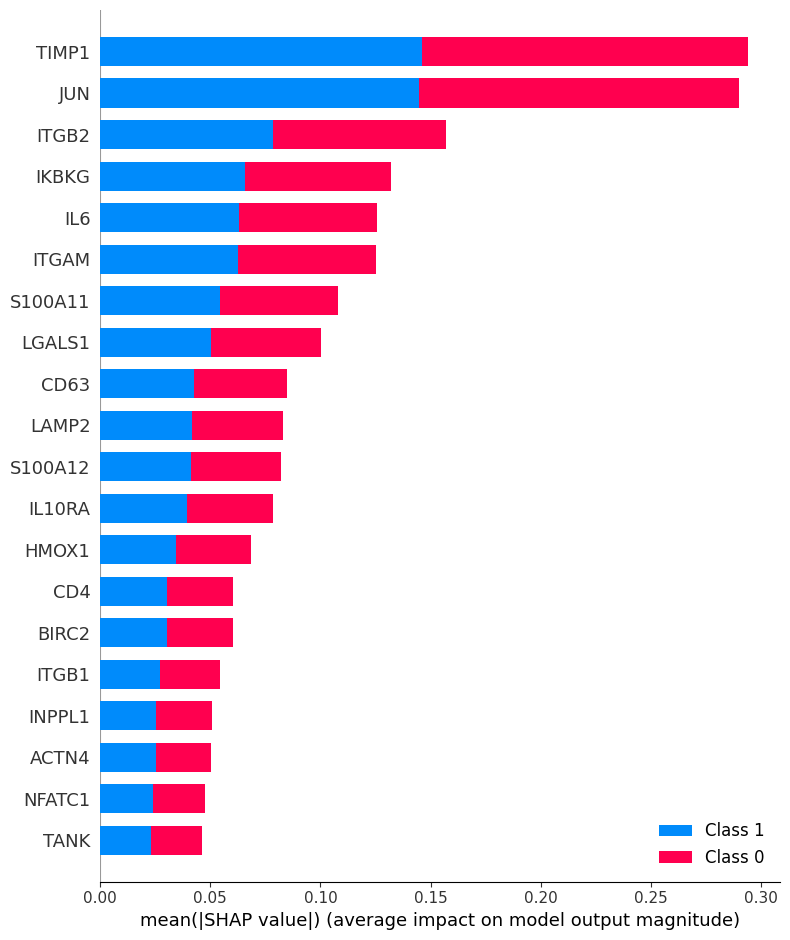

In [ ]:
# SHAP values for explainable AI
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_eval)

# Load and prepare training data
tr_dt = pd.read_excel("ins/MGH_TRAINING.xlsx").drop(['Condition'], axis=1)
tr_dt = tr_dt.drop('Unnamed: 0', axis=1)

# Calculate average absolute SHAP values for feature importance
vals = np.abs(shap_values).mean(axis=1).mean(axis=0)  # Mean SHAP values across all samples and classes
feature_importance = pd.DataFrame(list(zip(tr_dt.columns, vals)), columns=['Feature', 'Importance'])

# Sort features by importance
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Generate and save the summary plot
fig = shap.summary_plot(shap_values, x_eval, feature_names=tr_dt.columns, max_display=20, show=False)
plt.savefig('outs/shap_values20_training.svg')
plt.savefig('outs/shap_values20_training.png', dpi=300)

# Save feature importance as csv
feature_importance.to_csv("outs/feature_importance_table_mgh_scmgh.csv", index=False)

## Testing model with Blish

In [ ]:
# Set the model to evaluation mode
model.eval()

# load test dataset
x_train, y_train = load_data("ins/MGH_TRAINING.xlsx", dtype)
x_test, y_test = load_data("ins/Blish_TESTING.xlsx", dtype)

# Perform inference without gradient computation
with torch.no_grad():
    pred_new = model(x_test)  # pred_new will be of shape [num_samples, 2] for binary classification

# Evaluate metrics
auc_score = auc(y_test, pred_new)
f1_score_val = f1(y_test, pred_new)

print("AUC on new dataset:", auc_score)
print("F1 on new dataset:", f1_score_val)

AUC on new dataset: 0.9837649541417974
F1 on new dataset: 0.7861918830663971


In [ ]:
np.savetxt("outs/PASNet_pred_Blish_testing.txt", pred_new.numpy(), delimiter = ",")

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


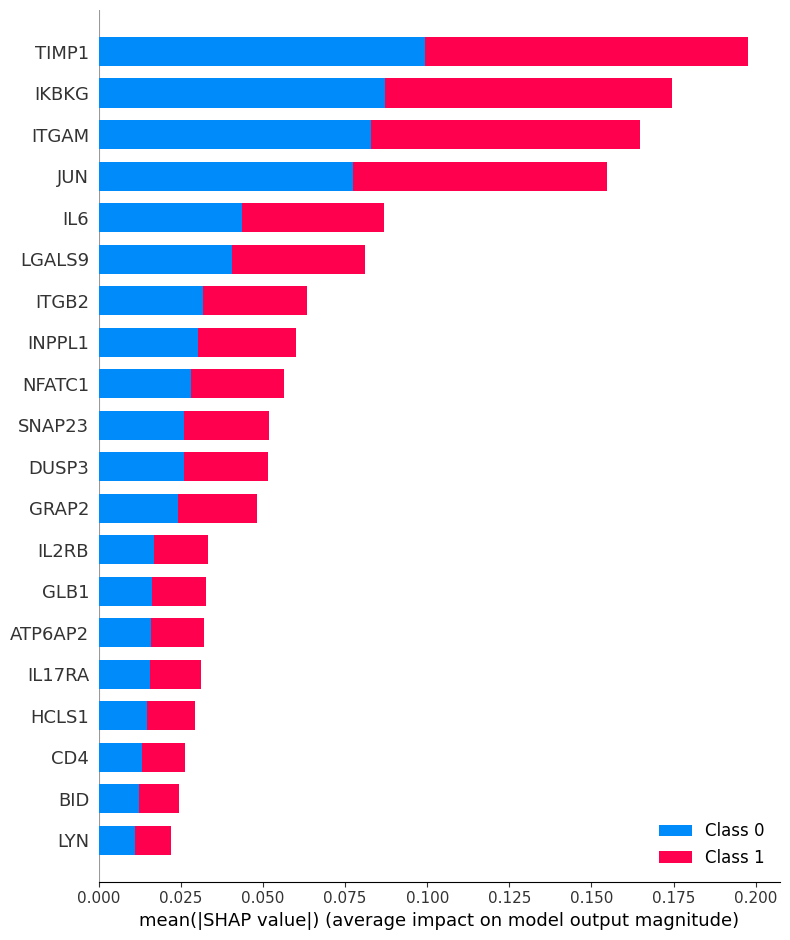

In [ ]:
# SHAP values for explainable AI
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

# Load and prepare training data
tr_dt = pd.read_excel("ins/MGH_TRAINING.xlsx").drop(['Condition'], axis=1)
tr_dt = tr_dt.drop('Unnamed: 0', axis=1)

# Calculate average absolute SHAP values for feature importance
vals = np.abs(shap_values).mean(axis=1).mean(axis=0)  # Mean SHAP values across all samples and classes
feature_importance = pd.DataFrame(list(zip(tr_dt.columns, vals)), columns=['Feature', 'Importance'])

# Sort features by importance
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Generate and save the summary plot
fig = shap.summary_plot(shap_values, x_test, feature_names=tr_dt.columns, max_display=20, show=False)
plt.savefig('outs/shap_values20_testing.svg')
plt.savefig('outs/shap_values20_testing.png', dpi=300)

# Save feature importance as csv
feature_importance.to_csv("outs/feature_importance_table_mgh_blish.csv", index=False)

In [ ]:
# Convert predictions and labels to CPU numpy arrays for additional metrics
Y_true_np = torch.argmax(y_test, dim=1).cpu().numpy()      # ground truth labels as integers
Y_pred_np = torch.argmax(pred_new, dim=1).cpu().numpy()   # predicted labels as integers

# Compute accuracy, precision, recall, and confusion matrix
accuracy = np.mean(Y_true_np == Y_pred_np)
precision_val = precision_score(Y_true_np, Y_pred_np)
recall_val = recall_score(Y_true_np, Y_pred_np)
cm = confusion_matrix(Y_true_np, Y_pred_np)

print("Accuracy on new dataset:", accuracy)
print("Precision on new dataset:", precision_val)
print("Recall on new dataset:", recall_val)
print("Confusion Matrix:")
print(cm)

Accuracy on new dataset: 0.7884615384615384
Precision on new dataset: 0.9952755905511811
Recall on new dataset: 0.6497044461578001
Confusion Matrix:
[[2597   12]
 [1363 2528]]


# Fix sc1_weights for Post-hoc Analysis

In [ ]:
# Load the dataframes
pt_fixed = pd.read_excel("ins/pt_fixed.xlsx", index_col=0)  # Assuming row names are in the first column
sc1_weights = pd.read_excel("outs/sc1_weights.xlsx", index_col=0)  # Assuming row names are in the first column

# Apply the row and column names from pt_fixed to sc1_weights
sc1_weights.columns = pt_fixed.columns
sc1_weights.index = pt_fixed.index

# Save the updated sc1_weights as sc1_weights_fixed
sc1_weights.to_excel("outs/sc1_weights_fixed.xlsx")